In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn

import Util
import tsGAN

import os

import matplotlib.pyplot as plt

import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [105]:
sns.set_style('white')
sns.set_context('poster')

In [3]:
# CSV path
folder_name = "data"
file_name = "hungary_chickenpox.csv"
path = os.path.join(folder_name, file_name)
#Load CSV into Dataframe
df = pd.read_csv(path,sep=',')
df = df.drop(columns = ['Date'])

In [4]:
# Get column names
names = Util.get_column_names(df)

In [5]:
df.keys()

Index(['BUDAPEST', 'BARANYA', 'BACS', 'BEKES', 'BORSOD', 'CSONGRAD', 'FEJER',
       'GYOR', 'HAJDU', 'HEVES', 'JASZ', 'KOMAROM', 'NOGRAD', 'PEST', 'SOMOGY',
       'SZABOLCS', 'TOLNA', 'VAS', 'VESZPREM', 'ZALA'],
      dtype='object')

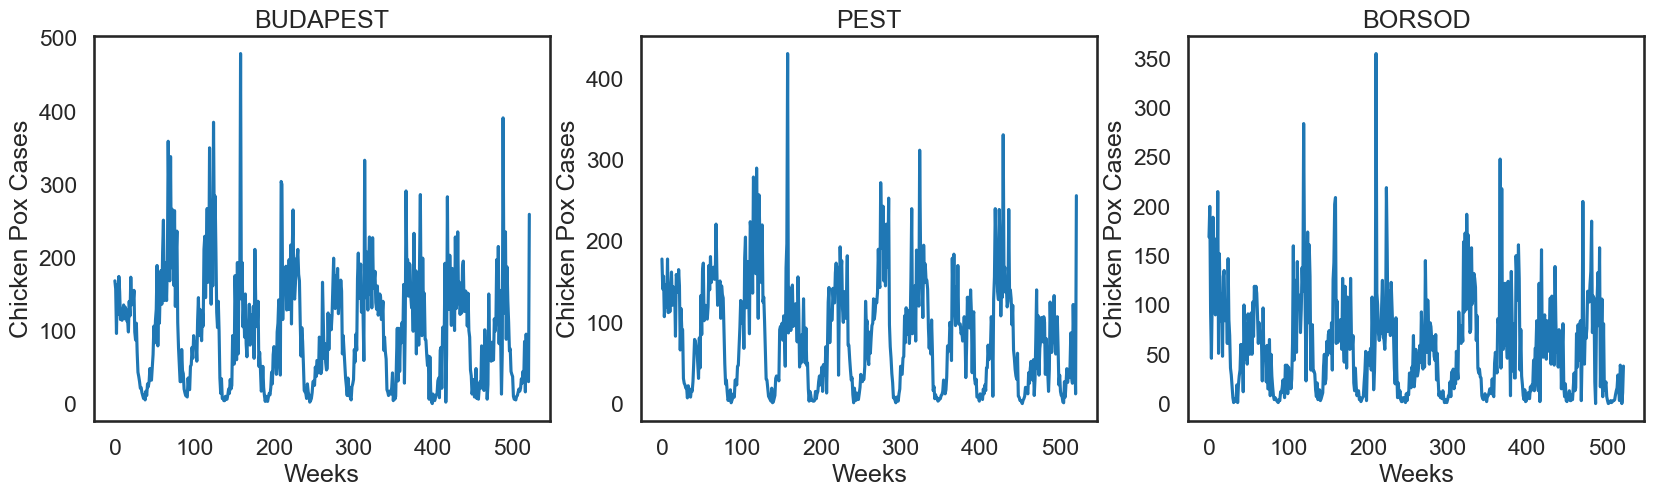

In [18]:
fig, axes = plt.subplots(1,3,figsize=(20,5))

sns.lineplot(data=df,x=df.index,y='BUDAPEST',ax=axes[0])
axes[0].set_xticks(np.arange(0,550,100))
axes[0].set_xlabel('Weeks')
axes[0].set_ylabel('Chicken Pox Cases')
axes[0].set_title('BUDAPEST')

sns.lineplot(data=df,x=df.index,y='PEST',ax=axes[1])
axes[1].set_xticks(np.arange(0,550,100))
axes[1].set_xlabel('Weeks')
axes[1].set_ylabel('Chicken Pox Cases')
axes[1].set_title('PEST')

sns.lineplot(data=df,x=df.index,y='BORSOD',ax=axes[2])
axes[2].set_xticks(np.arange(0,550,100))
axes[2].set_xlabel('Weeks')
axes[2].set_ylabel('Chicken Pox Cases')
axes[2].set_title('BORSOD');

In [7]:
# Set random state
torch.manual_seed(111)
# Select # of data points from data set to train GAN
num_data = 522

# Specify dimensionality of dataframe
df_dim = len(df.columns)
# learning rate
lr = 0.002
# number of epoch
num_epochs = 100
# Discriminator and Generator dropout fro data standardization
drop_out=0.2
# Define batch size for the data loader
batch_size = 18


# These create the arrays and then turns them into tensors for the train loader 
arrays = Util.create_arrays(df[:num_data],num_data)
train_set = Util.create_tensors(arrays)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)

In [8]:
generator = tsGAN.Generator(df_dim,batch_size,drop_out)
discriminator =  tsGAN.Discriminator(df_dim,batch_size,drop_out)

In [9]:
tsGAN.training_loop(generator, discriminator, num_epochs, train_loader, batch_size,lr,df_dim)

Epoch: 0 Loss D.: 0.3395146131515503
Epoch: 0 Loss G.: 0.7189307808876038
Epoch: 10 Loss D.: 0.1391613781452179
Epoch: 10 Loss G.: 1.3584651947021484
Epoch: 20 Loss D.: 0.011689942330121994
Epoch: 20 Loss G.: 4.367469787597656
Epoch: 30 Loss D.: 0.012725369073450565
Epoch: 30 Loss G.: 3.618648052215576
Epoch: 40 Loss D.: 0.03637952730059624
Epoch: 40 Loss G.: 4.107489109039307
Epoch: 50 Loss D.: 0.0056822095066308975
Epoch: 50 Loss G.: 4.592551231384277
Epoch: 60 Loss D.: 0.013590808026492596
Epoch: 60 Loss G.: 3.9882192611694336
Epoch: 70 Loss D.: 0.09803619980812073
Epoch: 70 Loss G.: 4.562300682067871
Epoch: 80 Loss D.: 0.1192009299993515
Epoch: 80 Loss G.: 2.98622465133667
Epoch: 90 Loss D.: 0.11777035146951675
Epoch: 90 Loss G.: 4.000824928283691


In [10]:
# After training the Gen, generates data as tensors
latent_space_samples = torch.randn((num_data), df_dim)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()

In [11]:
# Takes the generated data and turns it into a pandas DataFrame
df_gen=pd.DataFrame(generated_samples, columns=names)
df_gen

,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,HEVES,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,68.049141,26.385830,2.357100,21.860418,-14.077543,23.236834,19.381813,50.604401,44.341393,9.370233,27.368380,39.130081,20.628857,57.211189,31.303711,19.544584,29.375563,24.414038,42.225052,16.571449
1,81.909180,30.222157,82.638649,13.243493,100.962189,20.377560,46.385708,47.054592,58.553726,28.934511,84.302376,22.532017,-7.493997,12.250928,4.089254,19.944756,5.349391,24.179134,50.747517,24.213900
2,29.557823,50.825443,49.868401,-19.438274,53.381687,24.313637,44.093761,33.310497,10.750972,4.444375,26.844337,10.632729,37.327339,91.182404,28.555063,5.883950,11.190838,31.873055,59.648262,2.111625
3,64.769112,32.927605,52.747677,-6.111316,75.843376,25.836246,28.093407,26.690887,18.950474,3.668201,51.976643,22.041145,30.106312,66.714661,21.759893,13.743771,34.941021,34.929222,69.116760,24.957525
4,100.964066,23.700937,32.358330,45.181843,23.474827,27.502131,31.274023,63.623108,83.019028,33.526646,49.502171,51.798950,0.969770,43.105270,22.995594,36.158997,18.440050,14.850147,39.038666,22.583941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,68.388443,26.870886,66.976173,0.324440,85.226395,20.147511,35.292339,32.809544,33.851551,13.016705,71.465675,20.968065,6.413507,27.679777,5.604160,12.582948,20.971849,29.756245,56.102798,23.283295
518,120.426407,25.985598,71.874908,24.759405,68.828392,28.748104,32.891418,41.276913,46.043438,14.442205,93.720329,42.037617,0.275036,25.960297,6.558292,20.869497,38.889256,48.008633,55.965462,40.194191
519,38.561626,50.479004,57.218941,-12.470945,71.338371,25.422056,53.479073,41.789482,26.198551,9.610817,29.562635,14.456409,34.771519,96.201424,31.647451,15.008986,5.329341,29.667778,65.554016,2.412764
520,46.668293,15.069393,39.758385,6.352544,45.099167,12.729368,21.395405,21.441387,23.663383,9.981543,43.313164,14.851430,0.251256,12.172738,3.761107,10.029046,10.192449,18.287607,28.815485,15.672802


Text(0.5, 1.0, 'BORSOD')

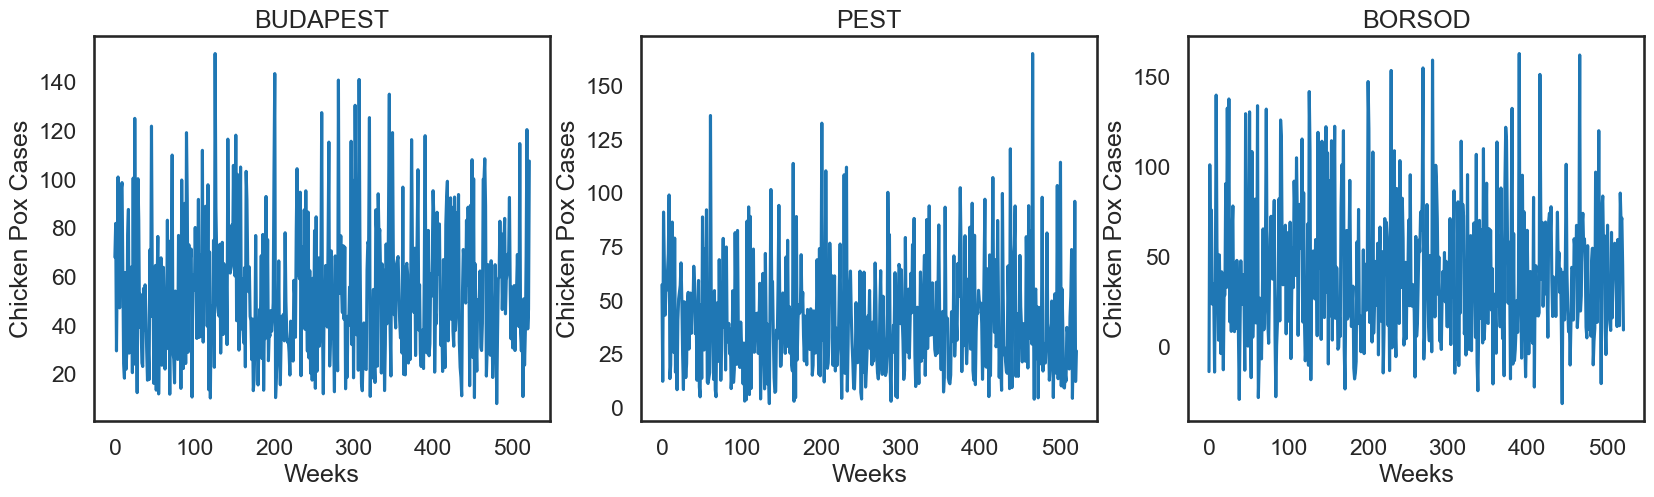

In [19]:
sns.set_style('white')
sns.set_context('talk')
fig, axes = plt.subplots(1,3, figsize=(20,5))
#fig.tight_layout()

sns.lineplot(data=df_gen, x=df.index, y='BUDAPEST', ax=axes[0])
axes[0].set_xlabel('Weeks')
axes[0].set_ylabel('Chicken Pox Cases')
axes[0].set_title('BUDAPEST')

sns.lineplot(data=df_gen, x=df.index, y='PEST', ax=axes[1])
axes[1].set_xlabel('Weeks')
axes[1].set_ylabel('Chicken Pox Cases')
axes[1].set_title('PEST')

sns.lineplot(data=df_gen, x=df.index, y='BORSOD', ax=axes[2])
axes[2].set_xlabel('Weeks')
axes[2].set_ylabel('Chicken Pox Cases')
axes[2].set_title('BORSOD')

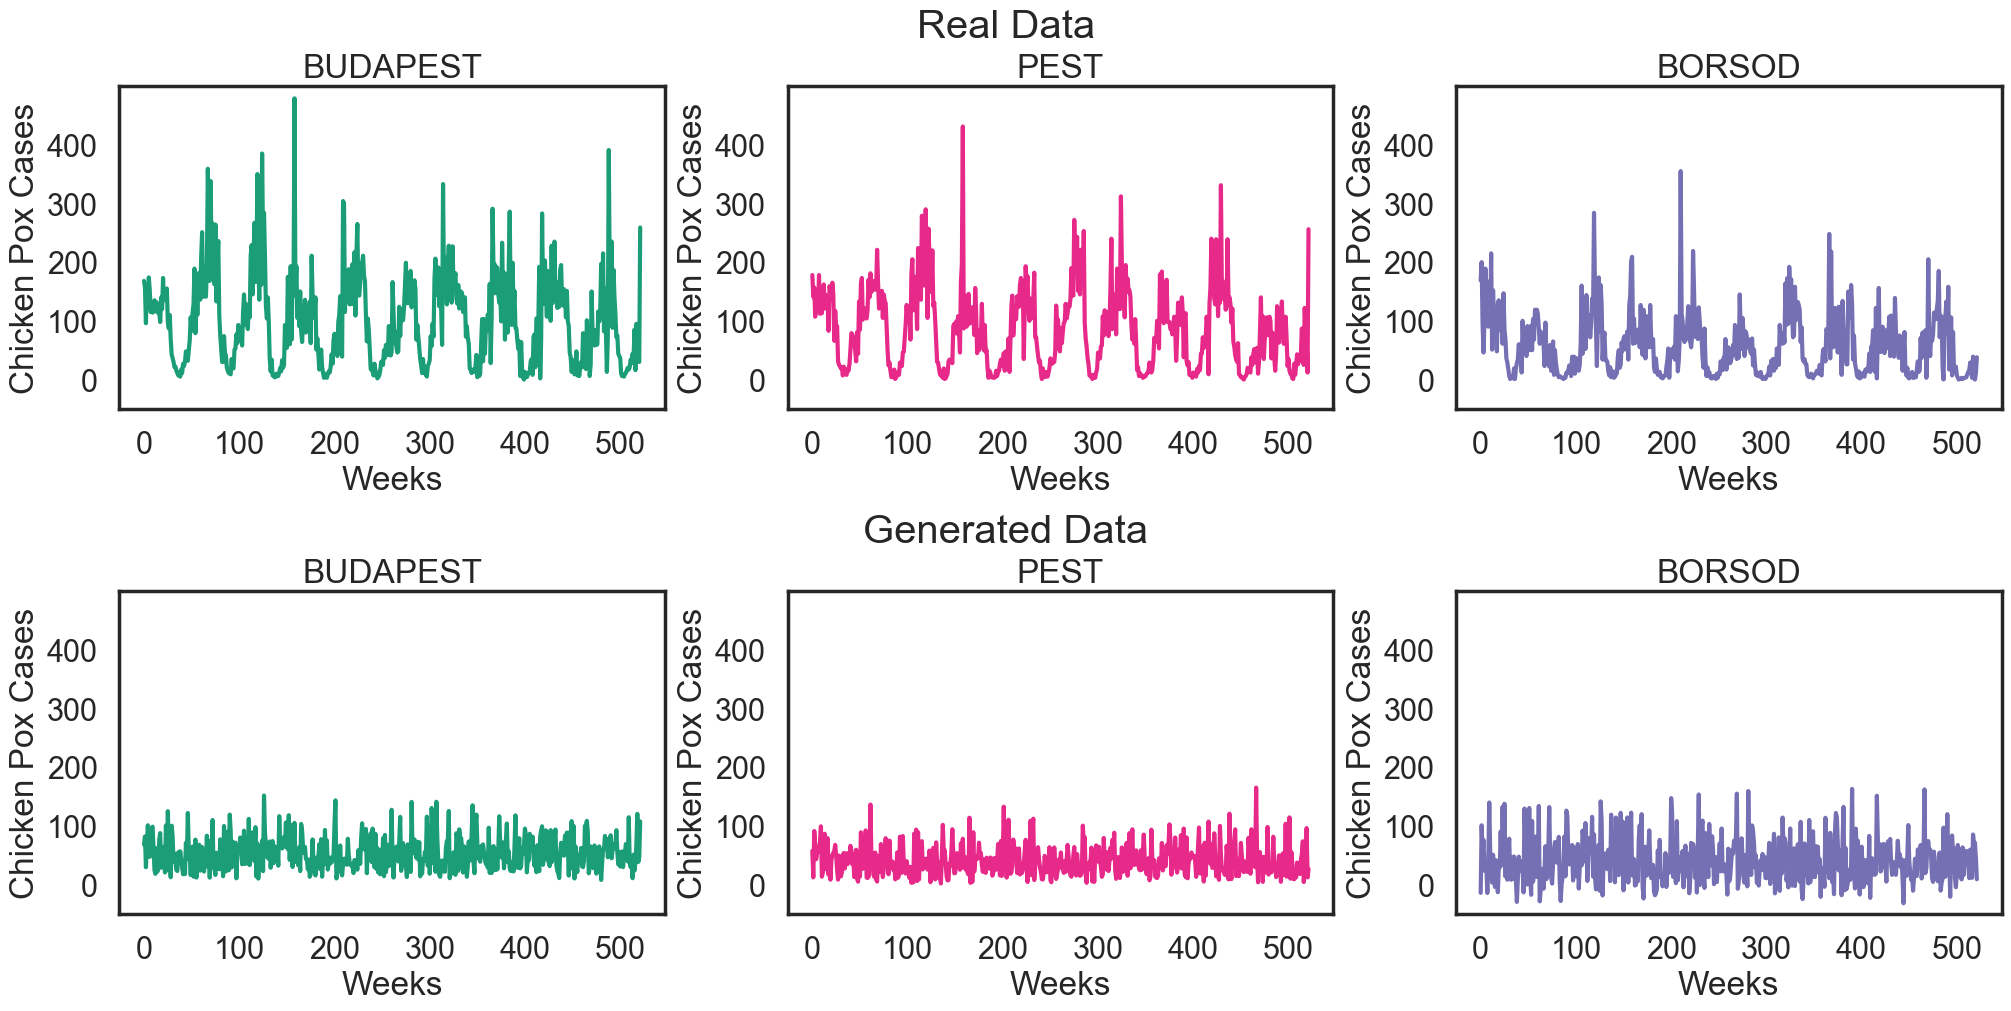

In [118]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))
#fig.suptitle('Real vs. Generated Data')

df_list = [df, df_gen]
colors = ['#1b9e77','#e7298a', '#7570b3']
sub_titles = ['Real Data', 'Generated Data']
plot_titles = ['BUDAPEST', 'PEST', 'BORSOD']

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(sub_titles[row])

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        sns.lineplot(data=df_list[row],x=df.iloc[0:].index,y=plot_titles[col], ax=axs[col], color=colors[col], alpha=1)
        ax.set_title(plot_titles[col])
        ax.set_xticks(np.arange(0,550,100))
        ax.set_ylim(-50, 500)
        ax.set_yticks(np.arange(0,500,100))
        ax.set_xlabel('Weeks')
        ax.set_ylabel('Chicken Pox Cases')

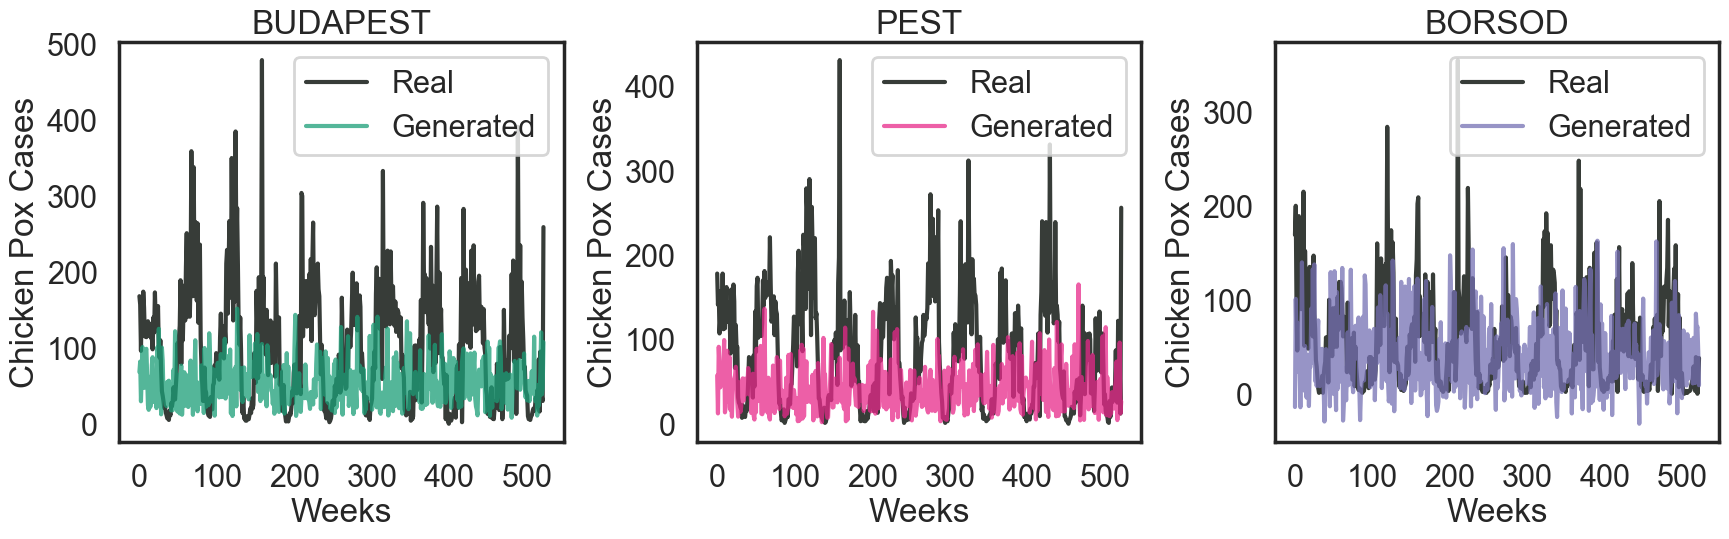

In [109]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.3)

sns.lineplot(data=df,x=df.index,y='BUDAPEST',ax=axes[0], color='#373c38', alpha=1, label='Real')
sns.lineplot(data=df_gen,x=df.index,y='BUDAPEST',ax=axes[0], color='#1b9e77', alpha=0.75, label='Generated')
axes[0].set_xticks(np.arange(0,550,100))
axes[0].set_xlabel('Weeks')
axes[0].set_ylabel('Chicken Pox Cases')
axes[0].set_title('BUDAPEST')

sns.lineplot(data=df,x=df.index,y='PEST',ax=axes[1], color='#373c38', label='Real')
sns.lineplot(data=df_gen, x=df.index, y='PEST', ax=axes[1], color='#e7298a', alpha=0.75, label='Generated')
axes[1].set_xticks(np.arange(0,550,100))
axes[1].set_xlabel('Weeks')
axes[1].set_ylabel('Chicken Pox Cases')
axes[1].set_title('PEST')

sns.lineplot(data=df,x=df.index,y='BORSOD',ax=axes[2], color='#373c38', label='Real')
sns.lineplot(data=df_gen, x=df.index, y='BORSOD', ax=axes[2], color='#7570b3', alpha=0.75, label='Generated')
axes[2].set_xticks(np.arange(0,550,100))
axes[2].set_xlabel('Weeks')
axes[2].set_ylabel('Chicken Pox Cases')
axes[2].set_title('BORSOD');

In [47]:
df['BUDAPEST'].head(100)

0     168
1     157
2      96
3     163
4     122
     ... 
95     51
96     53
97     77
98     62
99     93
Name: BUDAPEST, Length: 100, dtype: int64

In [56]:
np.arange(0,53, 4)

array([ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52])

In [91]:
df_list[1]

,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,HEVES,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,68.049141,26.385830,2.357100,21.860418,-14.077543,23.236834,19.381813,50.604401,44.341393,9.370233,27.368380,39.130081,20.628857,57.211189,31.303711,19.544584,29.375563,24.414038,42.225052,16.571449
1,81.909180,30.222157,82.638649,13.243493,100.962189,20.377560,46.385708,47.054592,58.553726,28.934511,84.302376,22.532017,-7.493997,12.250928,4.089254,19.944756,5.349391,24.179134,50.747517,24.213900
2,29.557823,50.825443,49.868401,-19.438274,53.381687,24.313637,44.093761,33.310497,10.750972,4.444375,26.844337,10.632729,37.327339,91.182404,28.555063,5.883950,11.190838,31.873055,59.648262,2.111625
3,64.769112,32.927605,52.747677,-6.111316,75.843376,25.836246,28.093407,26.690887,18.950474,3.668201,51.976643,22.041145,30.106312,66.714661,21.759893,13.743771,34.941021,34.929222,69.116760,24.957525
4,100.964066,23.700937,32.358330,45.181843,23.474827,27.502131,31.274023,63.623108,83.019028,33.526646,49.502171,51.798950,0.969770,43.105270,22.995594,36.158997,18.440050,14.850147,39.038666,22.583941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,68.388443,26.870886,66.976173,0.324440,85.226395,20.147511,35.292339,32.809544,33.851551,13.016705,71.465675,20.968065,6.413507,27.679777,5.604160,12.582948,20.971849,29.756245,56.102798,23.283295
518,120.426407,25.985598,71.874908,24.759405,68.828392,28.748104,32.891418,41.276913,46.043438,14.442205,93.720329,42.037617,0.275036,25.960297,6.558292,20.869497,38.889256,48.008633,55.965462,40.194191
519,38.561626,50.479004,57.218941,-12.470945,71.338371,25.422056,53.479073,41.789482,26.198551,9.610817,29.562635,14.456409,34.771519,96.201424,31.647451,15.008986,5.329341,29.667778,65.554016,2.412764
520,46.668293,15.069393,39.758385,6.352544,45.099167,12.729368,21.395405,21.441387,23.663383,9.981543,43.313164,14.851430,0.251256,12.172738,3.761107,10.029046,10.192449,18.287607,28.815485,15.672802


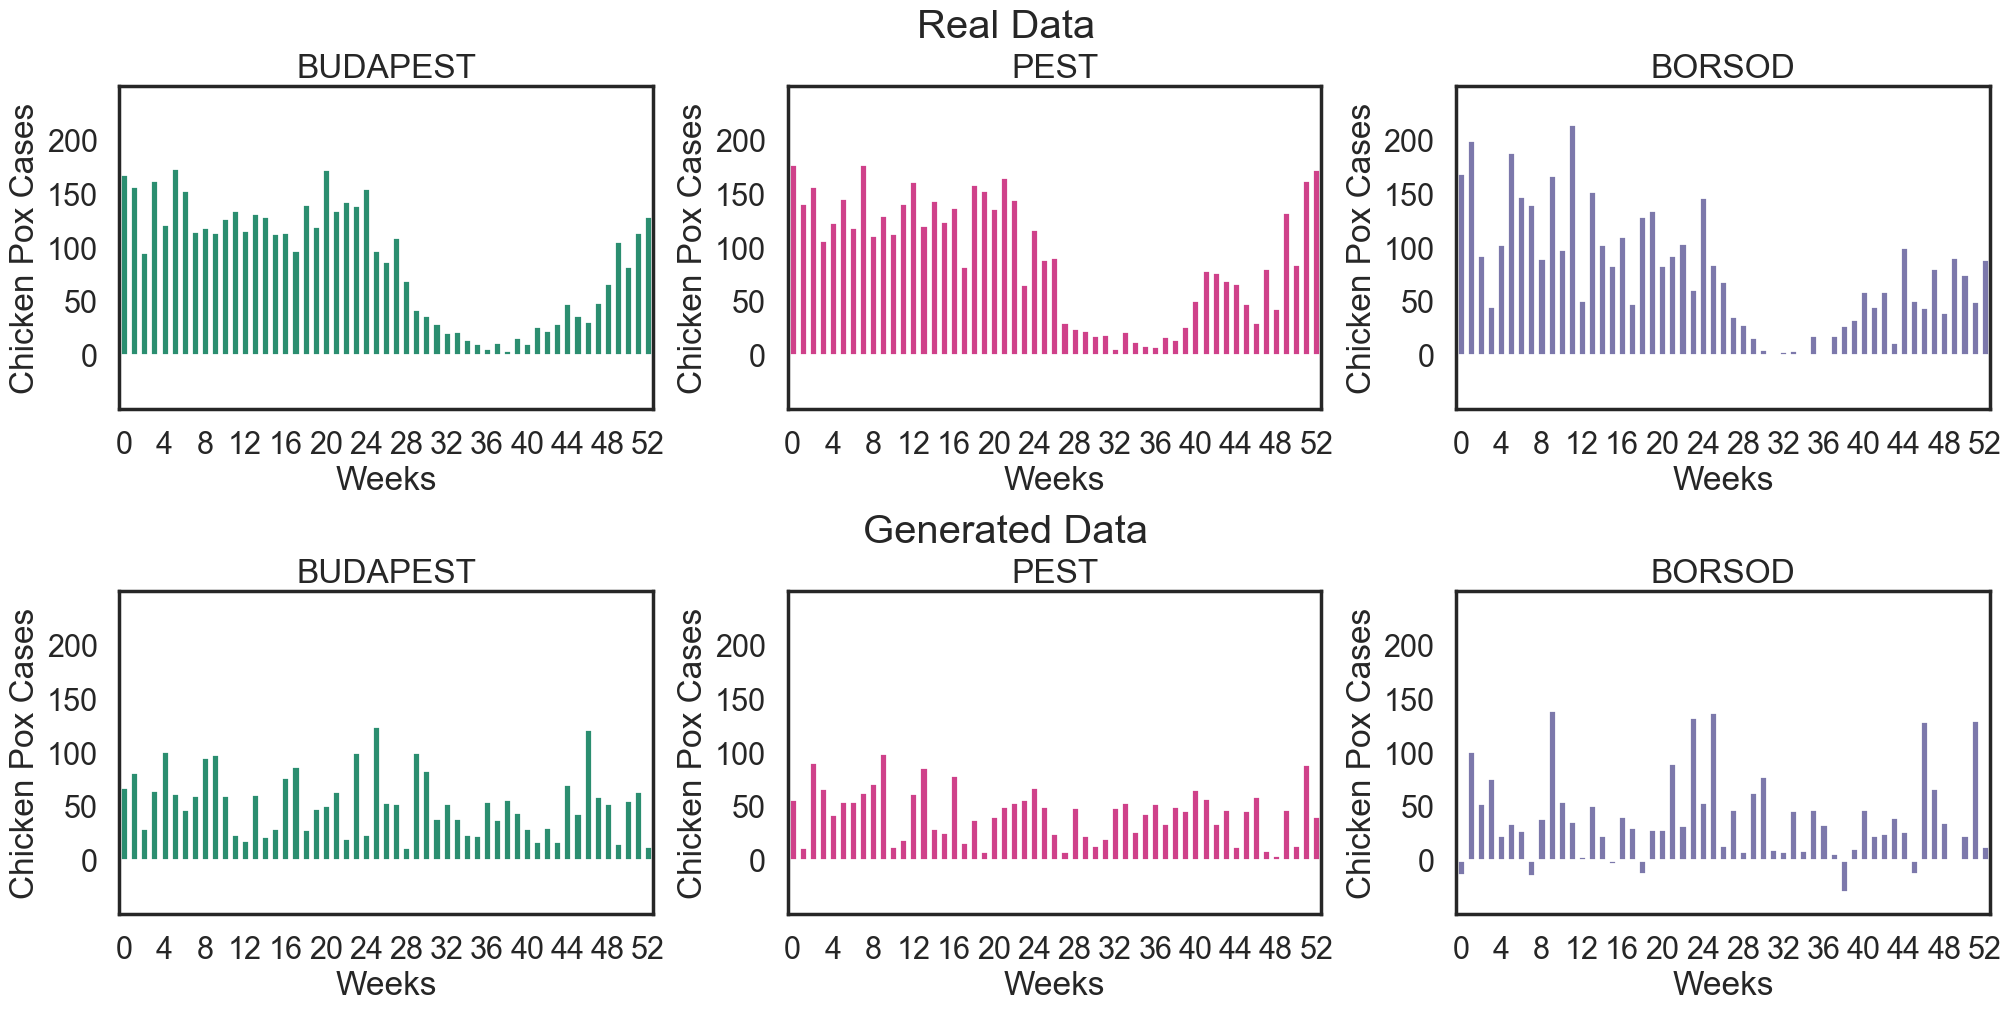

In [120]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))
#fig.suptitle('Real vs. Generated Data')

df_list = [df.head(53), df_gen.head(53)]
colors = ['#1b9e77','#e7298a', '#7570b3']
sub_titles = ['Real Data', 'Generated Data']
plot_titles = ['BUDAPEST', 'PEST', 'BORSOD']

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(sub_titles[row])

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        sns.barplot(data=df_list[row],x=df.iloc[0:53].index,y=plot_titles[col], ax=axs[col], color=colors[col], alpha=1)
        ax.set_title(plot_titles[col])
        ax.set_xticks(np.arange(0,53,4))
        ax.set_ylim(-50, 250)
        ax.set_yticks(np.arange(0,250,50))
        ax.set_xlabel('Weeks')
        ax.set_ylabel('Chicken Pox Cases')


Text(0, 0.5, 'Chicken Pox Cases')

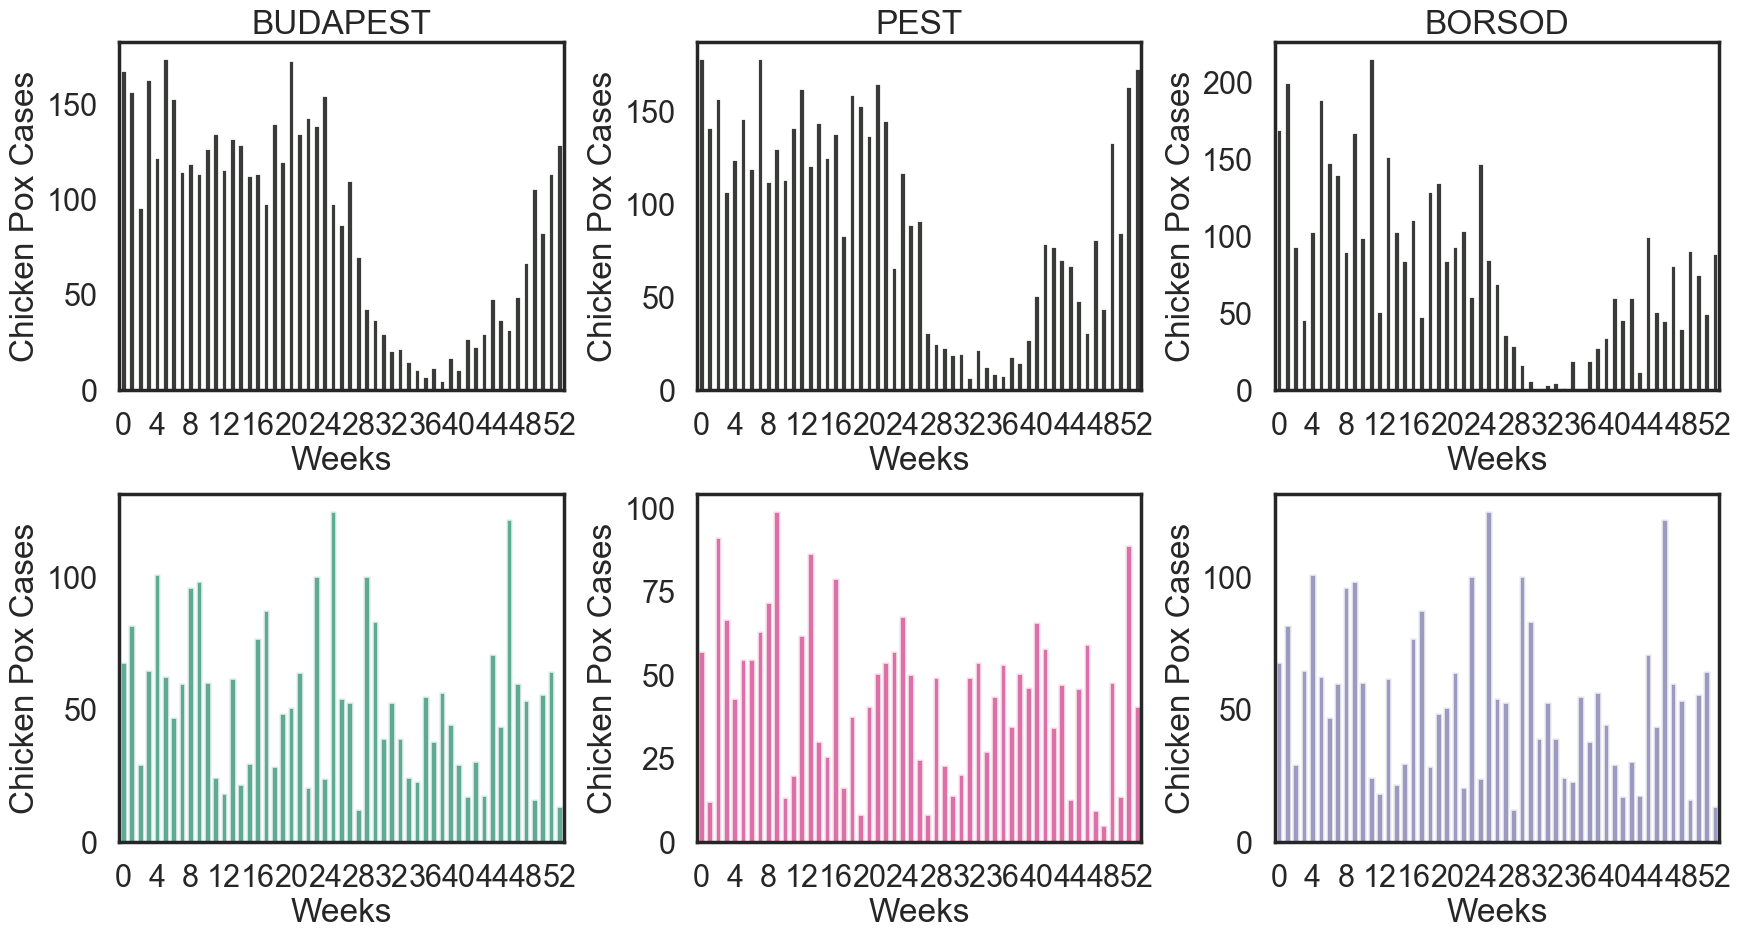

In [107]:
fig, axes = plt.subplots(2,3,figsize=(20,10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.3)

subfigs = fig.subfigures

sns.barplot(data=df,x=df.iloc[0:53].index,y=df['BUDAPEST'].head(53),ax=axes[0,0], color='#373c38', alpha=1, label='Real')
axes[0,0].set_xticks(np.arange(0,53,4))
axes[0,0].set_xlabel('Weeks')
axes[0,0].set_ylabel('Chicken Pox Cases')
axes[0,0].set_title('BUDAPEST')

sns.barplot(data=df,x=df.iloc[0:53].index,y=df['PEST'].head(53),ax=axes[0,1], color='#373c38', label='Real')
axes[0,1].set_xticks(np.arange(0,53,4))
axes[0,1].set_xlabel('Weeks')
axes[0,1].set_ylabel('Chicken Pox Cases')
axes[0,1].set_title('PEST')

sns.barplot(data=df,x=df.iloc[0:53].index,y=df['BORSOD'].head(53),ax=axes[0,2], color='#373c38', label='Real')
axes[0,2].set_xticks(np.arange(0,53,4))
axes[0,2].set_xlabel('Weeks')
axes[0,2].set_ylabel('Chicken Pox Cases')
axes[0,2].set_title('BORSOD')

sns.barplot(data=df_gen,x=df.iloc[0:53].index,y=df_gen['BUDAPEST'].head(53),ax=axes[1,0], color='#1b9e77', alpha=0.75, label='Generated')
axes[1,0].set_xticks(np.arange(0,53,4))
axes[1,0].set_xlabel('Weeks')
axes[1,0].set_ylabel('Chicken Pox Cases')

sns.barplot(data=df_gen, x=df.iloc[0:53].index, y=df_gen['PEST'].head(53), ax=axes[1,1], color='#e7298a', alpha=0.75, label='Generated')
axes[1,1].set_xticks(np.arange(0,53,4))
axes[1,1].set_xlabel('Weeks')
axes[1,1].set_ylabel('Chicken Pox Cases')

sns.barplot(data=df_gen, x=df.iloc[0:53].index, y=df_gen['BUDAPEST'].head(53), ax=axes[1,2], color='#7570b3', alpha=0.75, label='Generated')
axes[1,2].set_xticks(np.arange(0,53,4))
axes[1,2].set_xlabel('Weeks')
axes[1,2].set_ylabel('Chicken Pox Cases')